In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("ca93.csv.gz",compression='gzip')
df.authorship.value_counts().head(30)

PER CURIAM    4769
GILBERT       1423
ROSS          1001
DENMAN         989
WALLACE        944
WILBUR         911
REINHARDT      849
WRIGHT         750
BARNES         741
SNEED          729
DUNIWAY        709
GOODWIN        706
HEALY          653
PREGERSON      653
HUNT           641
HAMLEY         633
MORROW         629
STEPHENS       627
MERRILL        611
RUDKIN         601
MATHEWS        573
KOZINSKI       567
SCHROEDER      557
CHAMBERS       556
CHOY           555
CANBY          522
FLETCHER       519
HUG            500
ELY            482
ALARCON        475
Name: authorship, dtype: int64

In [3]:
df.authorship = df.authorship.str.upper()
names = []
for i in df.authorship.value_counts().head(100).index:
    if i != 'PER CURIAM' and i != 'PER CURIAM:':
        names.append(i)
copy = pd.DataFrame()
temp = df[df.word_count > 50]
for name in names:
    copy = copy.append(temp[temp.authorship == name])
copy.date_standard = copy.date_standard.str[:4]
copy.date_standard = copy.date_standard.astype(int)
copy = copy.drop(columns=['opinion_type','opinion_id','word_count','authors','dc_source','judges_refined'])
copy

,dc_identifier,opinion,authorship,date_standard
371,3S4X-19W0-003B-K481-00000-00,"Before GILBERT, HUNT, and RUDKIN, Circuit Judg...",GILBERT,1926
425,3S4W-YY80-003B-K1SK-00000-00,"Before GILBERT, RUDKIN, and DIETRICH, Circuit ...",GILBERT,1929
435,3S4X-0TX0-003B-J2F6-00000-00,"Before McKENNA and GILBERT, Circuit Judges, an...",GILBERT,1894
523,3S4W-YW80-003B-K1B0-00000-00,"Before GILBERT, RUDKIN, and DIETRICH, Circuit ...",GILBERT,1929
615,3S4X-0NM0-003B-J1SJ-00000-00,"Before GILBERT, Circuit Judge, and KNOWLES and...",GILBERT,1894
...,...,...,...,...
54324,5CH6-P0R1-F04K-V0K6-00000-00,"O'SCANNLAIN, Circuit Judge, joined by BYBEE an...",O'SCANNLAIN,2014
60184,3S4X-DDP0-008H-V55T-00000-00,"O'SCANNLAIN, Circuit Judge \n\nWe are asked to...",O'SCANNLAIN,1991
60947,4PSD-YB80-TXFX-D364-00000-00,"O'SCANNLAIN, Circuit Judge, joined by KOZINSKI...",O'SCANNLAIN,2007
62019,7X2X-3R10-YB0V-P001-00000-00,"O'SCANNLAIN, Circuit Judge, dissenting from th...",O'SCANNLAIN,2009


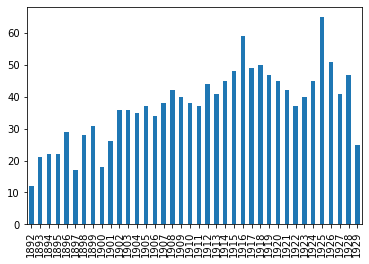

In [4]:
copy[copy.authorship == names[0]].date_standard.value_counts().sort_index().plot(kind='bar')

In [5]:
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge','')
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Senior District Judge','')
copy.opinion = copy.opinion.str.replace('Senior District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judges','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGES','')
copy.opinion = copy.opinion.str.replace('District Judges','')
copy.opinion = copy.opinion.str.replace('District Judges'.upper(),'')
copy.opinion = copy.opinion.str.replace('District Judge','')
copy.opinion = copy.opinion.str.replace('District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judge','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGE','')
copy.opinion = copy.opinion.str.replace('Circuit Justice','')
copy.opinion = copy.opinion.str.replace('Circuit Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('D\.J\.','')
copy.opinion = copy.opinion.str.replace('D\. J\.','')
copy.opinion = copy.opinion.str.replace('C\.J\.','')
copy.opinion = copy.opinion.str.replace('C\. J\.','')
copy.opinion = copy.opinion.str.replace('Senior Judge','')
copy.opinion = copy.opinion.str.replace('Senior Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Associate Justice','')
copy.opinion = copy.opinion.str.replace('Associate Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('Chief Judge','')
copy.opinion = copy.opinion.str.replace('Chief Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Judge','')
copy.opinion = copy.opinion.str.replace('Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('HONORABLE','')

for name in names:
    copy.opinion = copy.opinion.str.replace(name.upper(),'')
    copy.opinion = copy.opinion.str.replace(name,'')
    copy.opinion = copy.opinion.str.replace(name[:1].upper()+name[1:].lower(),'')




copy.opinion = copy.opinion.str.replace('STEPHEN',' ')
copy.opinion = copy.opinion.str.replace('Stephen',' ')
copy.opinion = copy.opinion.str.replace('ALFRED',' ')
copy.opinion = copy.opinion.str.replace('Alfred',' ')
copy.opinion = copy.opinion.str.replace('W\.',' ')
copy.opinion = copy.opinion.str.replace('B\.',' ')
copy.opinion = copy.opinion.str.replace('BETTY',' ')
copy.opinion = copy.opinion.str.replace('Betty',' ')
copy.opinion = copy.opinion.str.replace('\n',' ')

In [6]:
copy.opinion = copy.opinion.str.replace('\\\'','')
copy.opinion = copy.opinion.str.replace('(','')
copy.opinion = copy.opinion.str.replace(')','')
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\w\.", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\,", ",", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\d+", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"-", "", x))
copy.opinion = copy.opinion.str.replace('S\.C\.','')
copy.opinion = copy.opinion.str.replace('Ct\.','Ct')
copy.opinion = copy.opinion.str.replace('Ed\.','Ed')
copy.opinion = copy.opinion.str.replace('Dec\.','Dec')
copy.opinion = copy.opinion.str.replace(' No\.',' No')
copy.opinion = copy.opinion.str.replace(' pt\.',' pt')
copy.opinion = copy.opinion.str.replace(' Rep\.',' Rep')
copy.opinion = copy.opinion.str.replace(' Tr\.',' Tr')
copy.opinion = copy.opinion.str.replace(' Arg\.',' Arg')
copy.opinion = copy.opinion.str.replace(' Nev\.',' Nev')
copy.opinion = copy.opinion.str.replace(' Rev\.',' Rev')
copy.opinion = copy.opinion.str.replace(' Stat\.',' Stat')
copy.opinion = copy.opinion.str.replace(' Cent\.',' Cent')
copy.opinion = copy.opinion.str.replace(' Ore\.',' Ore')
copy.opinion = copy.opinion.str.replace(' Co\.',' Co')
copy.opinion = copy.opinion.str.replace(' Ins\.',' Ins')
copy.opinion = copy.opinion.str.replace('S\.','')
copy.opinion = copy.opinion.str.replace('Cf\.','Cf')
copy.opinion = copy.opinion.str.replace('Id\.','Id')
copy.opinion = copy.opinion.str.replace(' ,',',')
copy.opinion = copy.opinion.str.replace(' \.','.')
copy.opinion = copy.opinion.str.replace('§','')
copy.opinion = copy.opinion.str.replace('$','')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',\.',',')
copy.opinion = copy.opinion.str.replace('"',' ')
copy.opinion = copy.opinion.str.replace('II','')
copy.opinion = copy.opinion.str.replace('III','')
copy.opinion = copy.opinion.str.replace('  ',' ')

In [7]:
# Prints the first 200 characters of the first 10 cleaned opinion texts of a given judge.
judge = 0
print(names[judge]+'\n')
for x in range(10):
    print(copy.opinion[copy.loc[copy.authorship==names[judge]].index[x]][:200]+'\n\n')

GILBERT

Before, and, The defendants assign error to certain of the findings of fact of the trial court certain of the rulings of that court upon the admission of evidence, and certain of the courts conclusion


Before, and DIETRICH, , On the writ of error two questions are presented: First, whether on March, the distraint proceeding was barred by the internal revenue law of  Stat ; and, second, whether the a


Before McKENNA and, and HAWLEY, , The plaintiff in error, a banking corporation of Milwaukee, Wis., brought an action for damages against the defendant in error for wrongful conversion of bales of hop


Before, and DIETRICH, , Three separate judgment orders were entered by the Board of Tax Appeals, and the three petitions for review have by stipulation of the parties been consolidated for considerati


Before, and KNOWLES and HAWLEY, , This appeal is taken from an interlocutory decree of the circuit court adjudging the patent sued upon to be valid, and the appellant, the defenda

In [8]:
#get rough estimate for total number of top 10 authors in all 3 splits
top = 2000
bot = 1970
split1 = pd.DataFrame()
for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split1 = split1.append(temp[temp.date_standard<=bot])
split2 = pd.DataFrame()
for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
split3 = pd.DataFrame()
for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split3 = split3.append(temp[temp.date_standard>=top])

for i in range(3):
    totalNum = split1.shape[0]+split2.shape[0]+split3.shape[0]
    print('totalNum = '+str(totalNum))
    print(split1.shape)
    print(split2.shape)
    print(split3.shape)    

    #initialize the splits so we can iterate over them
    top = 2020
    bot = 1800
    split1 = pd.DataFrame()
    for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split1 = split1.append(temp[temp.date_standard<=bot])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    split3 = pd.DataFrame()
    for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split3 = split3.append(temp[temp.date_standard>=top])
    
    
    
    
    #loop to iterate 
    while split1.shape[0] < totalNum/3:
        bot += 1
        split1 = pd.DataFrame()
        for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split1 = split1.append(temp[temp.date_standard<=bot])    
    while split3.shape[0] < totalNum/3:
        top -= 1
        split3 = pd.DataFrame()
        for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split3 = split3.append(temp[temp.date_standard>=top])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    

    print(split1.shape)
    print(split2.shape)
    print(split3.shape)
    print('top = '+str(top)+' bot = '+str(bot))

totalNum = 15237
(7967, 4)
(6066, 4)
(1204, 4)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(5206, 4)
(6066, 4)
(5214, 4)
top = 1983 bot = 1937
totalNum = 16486
(5206, 4)
(6066, 4)
(5214, 4)
(5586, 4)
(5649, 4)
(5670, 4)
top = 1981 bot = 1939
totalNum = 16905
(5586, 4)
(5649, 4)
(5670, 4)
(5783, 4)
(5500, 4)
(5670, 4)
top = 1981 bot = 1940


# Bag of Words approach

## Split 1

In [9]:
split1.authorship.value_counts()

GILBERT     1420
ROSS         972
WILBUR       808
HUNT         637
MORROW       627
RUDKIN       599
DENMAN       255
MATHEWS      210
HEALY        140
STEPHENS     115
Name: authorship, dtype: int64

In [10]:
print('Number of Datapoints: ', split1.shape[0])

Number of Datapoints:  5783


In [11]:
split1names = split1.authorship.unique()

for index, name in enumerate(split1names):
    split1.authorship = split1.authorship.str.replace(name, str(index))
split1.authorship = split1.authorship.astype(int)

In [12]:
vectorizer1 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM1 = vectorizer1.fit_transform(split1.opinion)
#print(bowM1.toarray().shape)
#print(vectorizer1.get_feature_names())

In [13]:
X1 = pd.DataFrame.sparse.from_spmatrix(bowM1)
X1 = X1.sparse.to_dense()

In [14]:
for x in range(0,len(X1.columns)):
    mean = X1.iloc[:,x].mean()
    std = X1.iloc[:,x].std()
    X1.iloc[:,x] = (X1.iloc[:,x] - mean)/std

In [15]:
Y1 = split1.authorship.to_frame().reset_index().drop(columns=['index'])

X1_Training, X1_Testing, y1_Training, y1_Testing = train_test_split(X1, Y1, test_size=0.2, random_state=1234)

In [16]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_Training, y1_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X1_train), np.array(y1_train))
    values = classifier.predict_proba(np.array(X1_test))
    
    correct = 0
    counter = 0
    for k in range(0,y1_test.size):
        if np.amax(values[k]) == values[k][int(y1_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8844492440604752


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8812095032397408


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8758099352051836


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.896328293736501


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8833693304535637
Accuracy:  0.8842332613390929  +/-  0.0067405989349145585


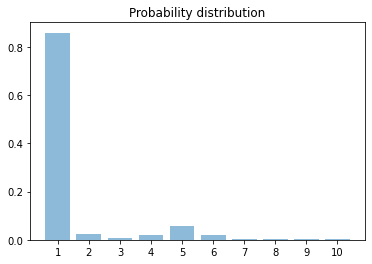

Accuracy:  0.881590319792567


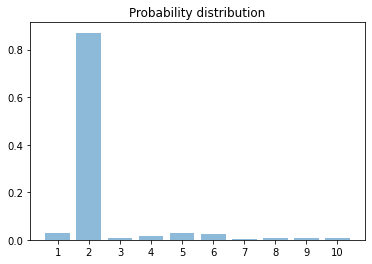

Accuracy:  0.881590319792567


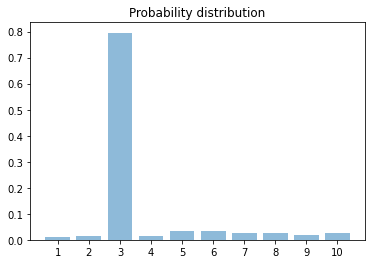

Accuracy:  0.881590319792567


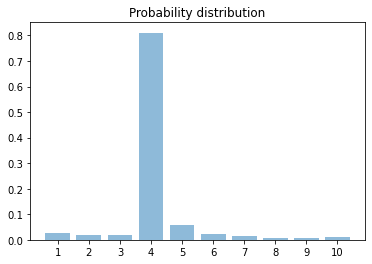

Accuracy:  0.881590319792567


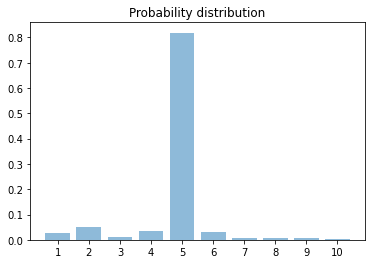

Accuracy:  0.881590319792567


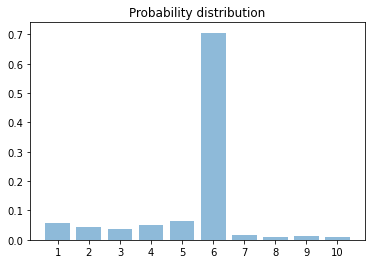

Accuracy:  0.881590319792567


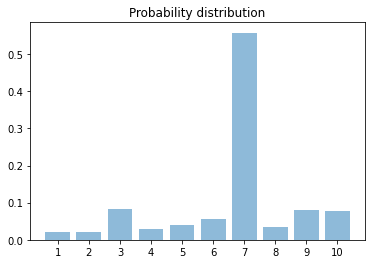

Accuracy:  0.881590319792567


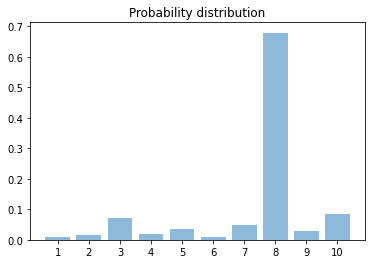

Accuracy:  0.881590319792567


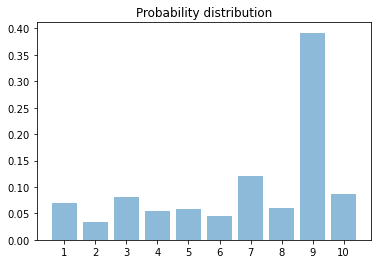

Accuracy:  0.881590319792567


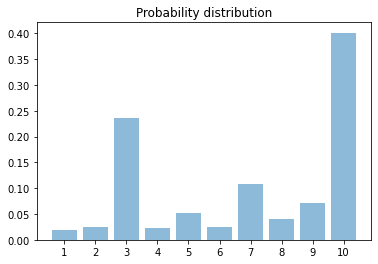

Accuracy:  0.881590319792567


In [17]:
values1 = classifier.predict_proba(np.array(X1_Testing))
data1 = pd.DataFrame(data=values1)
data1['Y'] = y1_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data1.to_csv('93_split1_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data1.iterrows():
        if(row['Y'] == l):
            for k in range(0,10):
                probs[k] += row[k]
            count += 1
    
    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y1_Testing.size):
        if np.amax(values1[k]) == values1[k][int(y1_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

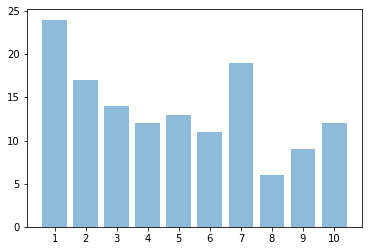

[24, 17, 14, 12, 13, 11, 19, 6, 9, 12]


In [18]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data1.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

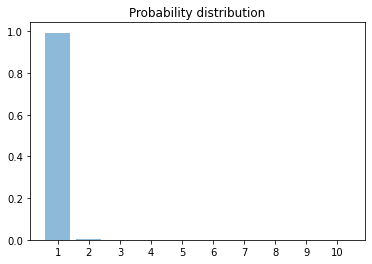

In [19]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values1[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 2

In [20]:
split2.authorship.value_counts()

DENMAN      732
BARNES      725
HAMLEY      633
DUNIWAY     625
MERRILL     532
HEALY       502
CHAMBERS    476
STEPHENS    470
ELY         439
WRIGHT      366
Name: authorship, dtype: int64

In [21]:
print('Number of Datapoints: ', split2.shape[0])

Number of Datapoints:  5500


In [22]:
split2names = split2.authorship.unique()

for index, name in enumerate(split2names):
    split2.authorship = split2.authorship.str.replace(name, str(index))
split2.authorship = split2.authorship.astype(int)

In [23]:
vectorizer2 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM2 = vectorizer2.fit_transform(split2.opinion)
#print(bowM2.toarray().shape)
#print(vectorizer2.get_feature_names())

In [24]:
X2 = pd.DataFrame.sparse.from_spmatrix(bowM2)
X2 = X2.sparse.to_dense()

In [25]:
for x in range(0,len(X2.columns)):
    mean = X2.iloc[:,x].mean()
    std = X2.iloc[:,x].std()
    X2.iloc[:,x] = (X2.iloc[:,x] - mean)/std

In [26]:
Y2 = split2.authorship.to_frame().reset_index().drop(columns=['index'])

X2_Training, X2_Testing, y2_Training, y2_Testing = train_test_split(X2, Y2, test_size=0.2, random_state=1234)

In [27]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_Training, y2_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X2_train), np.array(y2_train))
    values = classifier.predict_proba(np.array(X2_test))
    
    correct = 0
    counter = 0
    for k in range(0,y2_test.size):
        if np.amax(values[k]) == values[k][int(y2_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8068181818181818


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8056818181818182


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8409090909090909


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8136363636363636


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7954545454545454
Accuracy:  0.8125  +/-  0.015347220923758327


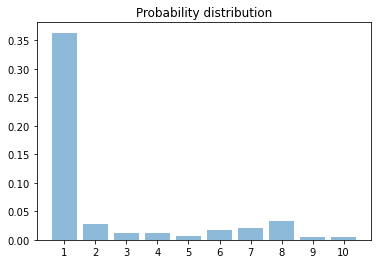

Accuracy:  0.8063636363636364


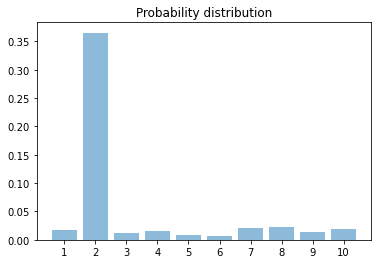

Accuracy:  0.8063636363636364


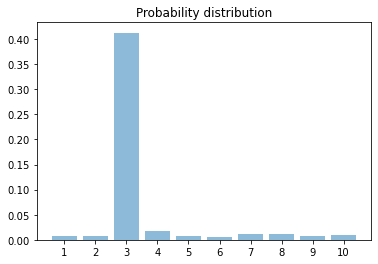

Accuracy:  0.8063636363636364


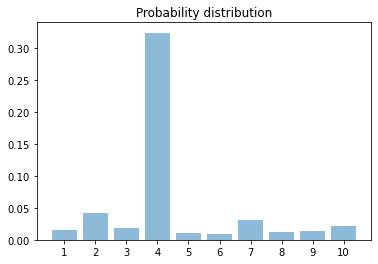

Accuracy:  0.8063636363636364


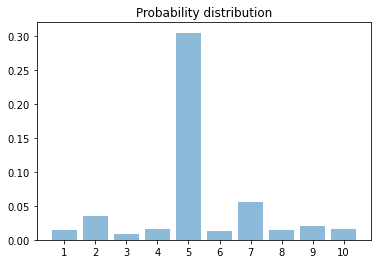

Accuracy:  0.8063636363636364


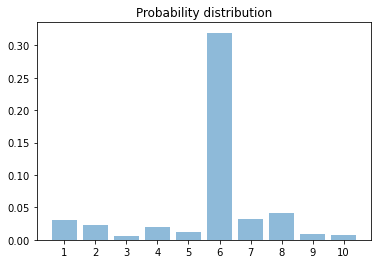

Accuracy:  0.8063636363636364


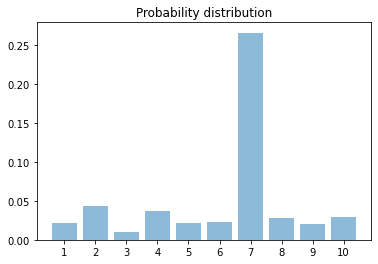

Accuracy:  0.8063636363636364


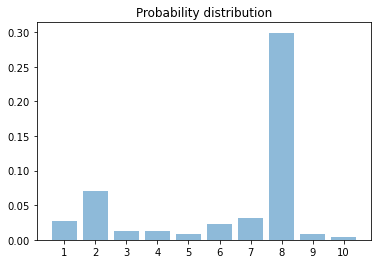

Accuracy:  0.8063636363636364


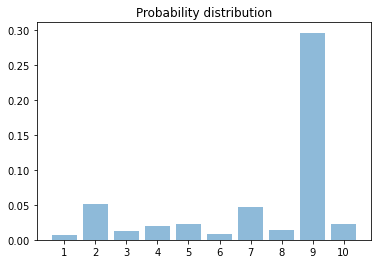

Accuracy:  0.8063636363636364


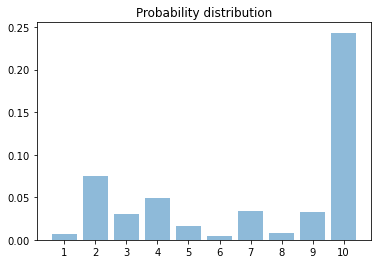

Accuracy:  0.8063636363636364


In [28]:
values2 = classifier.predict_proba(np.array(X2_Testing))
data2 = pd.DataFrame(data=values2)
data2['Y'] = y2_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data2.to_csv('93_split2_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data2.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y2_Testing.size):
        if np.amax(values2[k]) == values2[k][int(y2_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

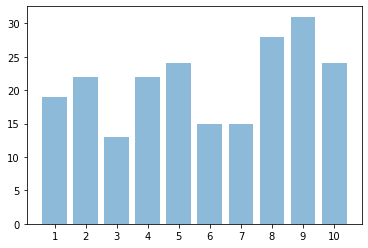

[19, 22, 13, 22, 24, 15, 15, 28, 31, 24]


In [29]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data2.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

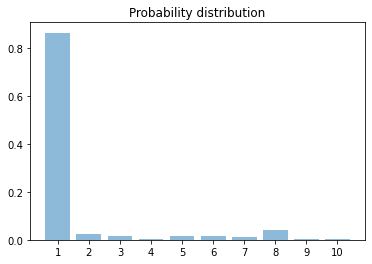

In [30]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values2[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 3

In [31]:
split3.authorship.value_counts()

REINHARDT      874
PREGERSON      667
WALLACE        627
KOZINSKI       568
SCHROEDER      533
CANBY          527
FLETCHER       512
O'SCANNLAIN    469
GOODWIN        457
SNEED          436
Name: authorship, dtype: int64

In [32]:
print('Number of Datapoints: ', split3.shape[0])

Number of Datapoints:  5670


In [33]:
split3names = split3.authorship.unique()

for index, name in enumerate(split3names):
    split3.authorship = split3.authorship.str.replace(name, str(index))
split3.authorship = split3.authorship.astype(int)

In [34]:
vectorizer3 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM3 = vectorizer3.fit_transform(split3.opinion)
#print(bowM3.toarray().shape)
#print(vectorizer3.get_feature_names())

In [35]:
X3 = pd.DataFrame.sparse.from_spmatrix(bowM3)
X3 = X3.sparse.to_dense()

In [36]:
for x in range(0,len(X3.columns)):
    mean = X3.iloc[:,x].mean()
    std = X3.iloc[:,x].std()
    X3.iloc[:,x] = (X3.iloc[:,x] - mean)/std

In [37]:
Y3 = split3.authorship.to_frame().reset_index().drop(columns=['index'])

X3_Training, X3_Testing, y3_Training, y3_Testing = train_test_split(X3, Y3, test_size=0.2, random_state=1234)

In [38]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_Training, y3_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X3_train), np.array(y3_train))
    values = classifier.predict_proba(np.array(X3_test))
    
    correct = 0
    counter = 0
    for k in range(0,y3_test.size):
        if np.amax(values[k]) == values[k][int(y3_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.5572687224669604


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.5462555066079295


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.5407488986784141


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.513215859030837


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.5748898678414097
Accuracy:  0.5464757709251101  +/-  0.020312144287926888


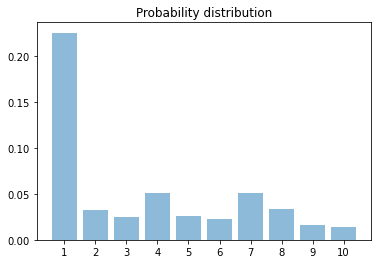

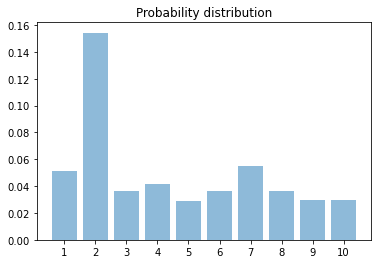

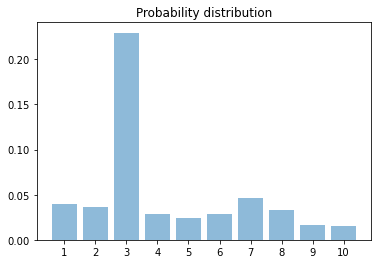

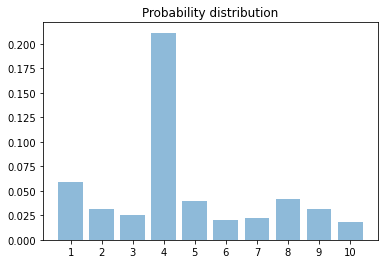

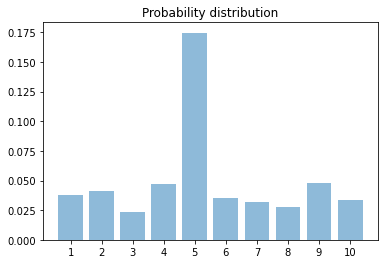

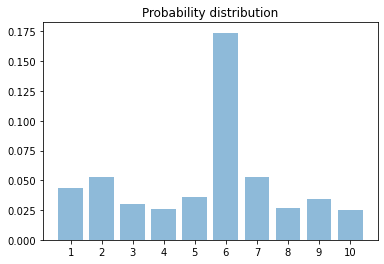

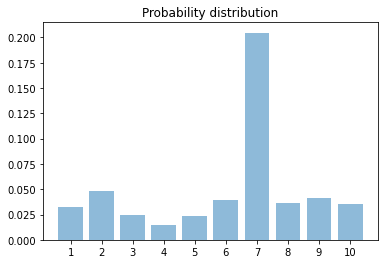

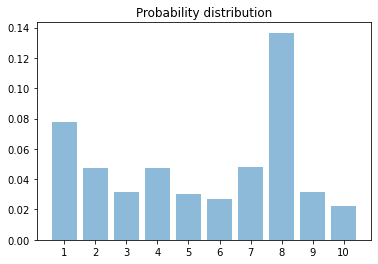

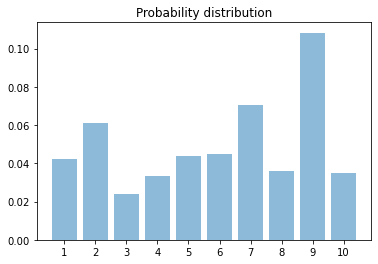

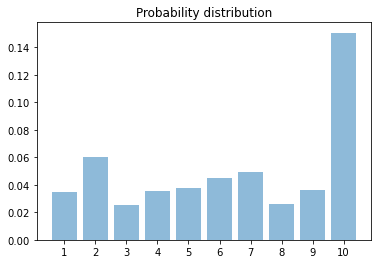

In [39]:
values3 = classifier.predict_proba(np.array(X3_Testing))
data3 = pd.DataFrame(data=values3)
data3['Y'] = y3_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data3.to_csv('93_split3_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data3.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()

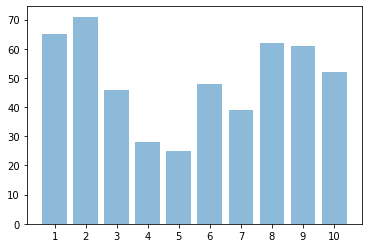

[65, 71, 46, 28, 25, 48, 39, 62, 61, 52]


In [40]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data3.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

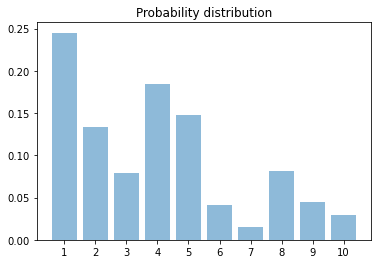

In [41]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values3[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()